In [2]:
# Importar librerías necesarias
import numpy as np  # Manipulación de arrays
import pandas as pd  # Manipulación de datos
import matplotlib.pyplot as plt  # Crear gráficos
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
import keras
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from keras.models import Sequential, Model, load_model
from keras.optimizers import Adam
from keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras import models, layers, optimizers, regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import BatchNormalization, Dropout
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import resample
import neattext.functions as nfx

In [4]:
file_path = 'emotion_sentimen_dataset.csv'

In [5]:
df = pd.read_csv(file_path)
df.head()

,Unnamed: 0,text,Emotion
0,0,i seriously hate one subject to death but now ...,hate
1,1,im so full of life i feel appalled,neutral
2,2,i sit here to write i start to dig out my feel...,neutral
3,3,ive been really angry with r and i feel like a...,anger
4,4,i feel suspicious if there is no one outside l...,neutral


In [6]:
df.drop(columns = ['Unnamed: 0'], inplace = True)

In [7]:
# Cargar los datos
data = df

# Separar las clases dominantes y minoritarias
majority_class = data[data.Emotion == 'neutral']
minority_classes = data[data.Emotion != 'neutral']

# Submuestrear la clase mayoritaria
majority_class_downsampled = resample(majority_class,
                                      replace=False,  # No reemplazar
                                      n_samples=300,  # Número de muestras deseado para la clase mayoritaria
                                      random_state=42)  # Asegurar reproducibilidad

# Combinar las clases minoritarias y la clase mayoritaria submuestreada
balanced_data = pd.concat([minority_classes, majority_class_downsampled])

# Sobremuestrear las clases minoritarias usando SMOTE
X = balanced_data['text']
y = balanced_data['Emotion']

In [8]:
# Eliminar stopwords
balanced_data['Clean_Text'] = balanced_data['text'].apply(nfx.remove_stopwords)

balanced_data.sample(15)

,text,Emotion,Clean_Text
360077,i was a toy to make me feel hated,hate,toy feel hated
829000,i am feeling much more energetic and happy,happiness,feeling energetic happy
770199,i feel heartbroken and shattered and dont know...,anger,feel heartbroken shattered dont know angels pa...
181796,i have sat down with many a sceptic and have t...,happiness,sat sceptic got gone away feeling drained life...
618521,i love the rainbow look that i have going on a...,love,love rainbow look going think feels festive ho...
195093,i feel joyful yet detached,fun,feel joyful detached
476949,i feel hated by father james martin s,hate,feel hated father james martin
256285,i find myself feeling very melancholy nonetheless,sadness,find feeling melancholy nonetheless
721675,i hate feeling helpless like im vulnerable lik...,hate,hate feeling helpless like im vulnerable like ...
621327,i feel hated unwanted and unloved,love,feel hated unwanted unloved


In [9]:
x = balanced_data['Clean_Text']
y = balanced_data['Emotion']

In [10]:
tfidf_vectorizer = TfidfVectorizer(max_features=2000, max_df=0.95, min_df=2)
X = tfidf_vectorizer.fit_transform(x)

In [11]:
if y.isnull().any():
    y.dropna(inplace=True)

# Mapear las emociones a números enteros
emotion_mapping = {
    'love': 0,
    'happiness': 1,
    'sadness': 2,
    'relief': 3,
    'hate': 4,
    'anger': 5,
    'fun': 6,
    'enthusiasm': 7,
    'surprise': 8,
    'empty': 9,
    'worry': 10,
    'neutral': 11,
    'boredom': 12
}

# Mapear y convertir a números enteros
y_int = y.map(emotion_mapping)

unexpected_values = set(y_int.unique()) - set(emotion_mapping.values())
if unexpected_values:
    print("Unexpected values in target labels:", unexpected_values)
    y_int.replace(unexpected_values, -1, inplace=True)

y_int_filtered = y_int[y_int != -1]

num_classes = len(emotion_mapping)
Y = to_categorical(y_int_filtered, num_classes=num_classes)

In [12]:
X = X.toarray()

In [13]:
#dividimos en train/test
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.15, random_state=42)

# MODELADO

Tareas a realizar:
* Contruir el modelo.
* Selección de la función de pérdida adecuada.
* Selección del optimizador (ej., Adam).
* Métricas de evaluación (ej., accuracy).
* Entrenar los modelos de machine learning (ML) a partir de conjuntos de datos más pequeños con resultados conocidos.
* Utilizar el modelo para analizar más a fondo conjuntos de datos desconocidos.

## Resumen del Modelo
* Capas Densas:
1. Primera capa densa con 256 unidades y activación ReLU.
2. Segunda capa densa con 128 unidades, activación ReLU y regularización L2 con un factor de 0.01.
3. Capa de salida con 13 unidades (correspondientes al número de clases) y activación softmax.  

* Normalización y Regularización:
1. Uso de BatchNormalization para mejorar la estabilidad y la velocidad del entrenamiento.
2. Dropout con una tasa del 50% en las dos primeras capas densas para prevenir el sobreajuste.

* Optimizador y Función de Pérdida:
1. Optimización mediante Adam con una tasa de aprendizaje inicial de 0.001.
2. Función de pérdida categórica (categorical_crossentropy) para clasificación multiclase.

* Callbacks:
1. ReduceLROnPlateau para reducir la tasa de aprendizaje si la pérdida de validación no mejora.
2. EarlyStopping para detener el entrenamiento temprano si no hay mejora en la pérdida de validación, restaurando los mejores pesos obtenidos.




In [14]:
num_classes = 13

model = models.Sequential()

model.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(layers.Dense(num_classes, activation='softmax'))

In [15]:
model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## ENTRENAR MODELO

In [16]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train,
    Y_train,
    epochs=35,
    batch_size=64,
    validation_data=(X_val, Y_val),
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/35
2196/2196 [==============================] - 20s 6ms/step - loss: 0.8052 - accuracy: 0.8794 - val_loss: 0.2581 - val_accuracy: 0.9552 - lr: 0.0010
Epoch 2/35
2196/2196 [==============================] - 13s 6ms/step - loss: 0.2762 - accuracy: 0.9490 - val_loss: 0.2245 - val_accuracy: 0.9623 - lr: 0.0010
Epoch 3/35
2196/2196 [==============================] - 14s 7ms/step - loss: 0.2377 - accuracy: 0.9576 - val_loss: 0.2054 - val_accuracy: 0.9661 - lr: 0.0010
Epoch 4/35
2196/2196 [==============================] - 13s 6ms/step - loss: 0.2156 - accuracy: 0.9630 - val_loss: 0.1923 - val_accuracy: 0.9708 - lr: 0.0010
Epoch 5/35
2196/2196 [==============================] - 13s 6ms/step - loss: 0.1965 - accuracy: 0.9678 - val_loss: 0.1814 - val_accuracy: 0.9742 - lr: 0.0010
Epoch 6/35
2196/2196 [==============================] - 13s 6ms/step - loss: 0.1831 - accuracy: 0.9714 - val_loss: 0.1726 - val_accuracy: 0.9760 - lr: 0.0010
Epoch 7/35
2196/2196 [==============================

# EVALUACIÓN

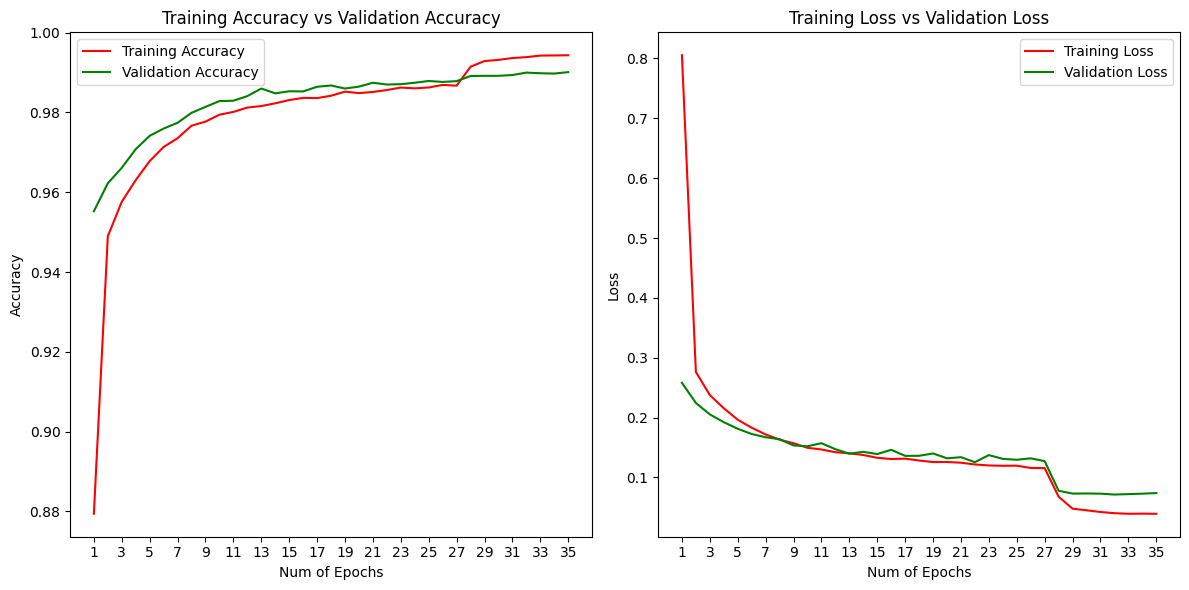

In [17]:
plt.figure(figsize=(12, 6))

# Gráfico de Accuracy
plt.subplot(1, 2, 1)  # Crear el primer subgráfico en una fila de dos
plt.plot(range(1, len(history.history['accuracy']) + 1), history.history['accuracy'], 'r', label='Training Accuracy')
# Graficar la precisión en entrenamiento en rojo
plt.plot(range(1, len(history.history['val_accuracy']) + 1), history.history['val_accuracy'], 'g', label='Validation Accuracy')
# Graficar la precisión en validación en verde
plt.xticks(np.arange(1, len(history.history['accuracy']) + 1, 2))  # Establecer marcas en el eje x cada dos épocas
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Validation Accuracy")
plt.legend()

# Gráfico de Loss
plt.subplot(1, 2, 2)  # Crear el segundo subgráfico en una fila de dos
plt.plot(range(1, len(history.history['loss']) + 1), history.history['loss'], 'r', label='Training Loss')
# Graficar la pérdida en entrenamiento en rojo
plt.plot(range(1, len(history.history['val_loss']) + 1), history.history['val_loss'], 'g', label='Validation Loss')
# Graficar la pérdida en validación en verde
plt.xticks(np.arange(1, len(history.history['loss']) + 1, 2))  # Establecer marcas en el eje x cada dos épocas
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend()

plt.tight_layout()  # Ajustar el diseño de los subgráficos para mejorar la legibilidad
plt.show()  # Mostrar los gráficos

In [18]:
# Evaluacion del modelo
test_loss, test_accuracy = model.evaluate(X_val, Y_val)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


775/775 [==============================] - 3s 4ms/step - loss: 0.0740 - accuracy: 0.9901
Test Loss: 0.073972687125206
Test Accuracy: 0.9901201725006104


# CONCLUSION

El modelo muestra una excelente precisión en los datos de prueba con una precisión del 99.01% y una pérdida baja de aproximadamente 0.074. Estos resultados sugieren que el modelo es muy efectivo para la tarea de clasificación propuesta y ha sido capaz de generalizar bien sobre los datos de validación.